In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *

In [3]:
pwd

'/content'

In [4]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
path='/content/drive/My Drive/Fast1ai/ship_category_hackathn/images'

In [0]:
# create a data bunch
np.random.seed(42)
data = ImageDataBunch.from_csv(path, ds_tfms=get_transforms(do_flip=True),size=(224,400),csv_labels='train.csv',valid_pct=0.25,);


In [0]:
len(data.train_ds), len(data.valid_ds)

(4689, 1563)

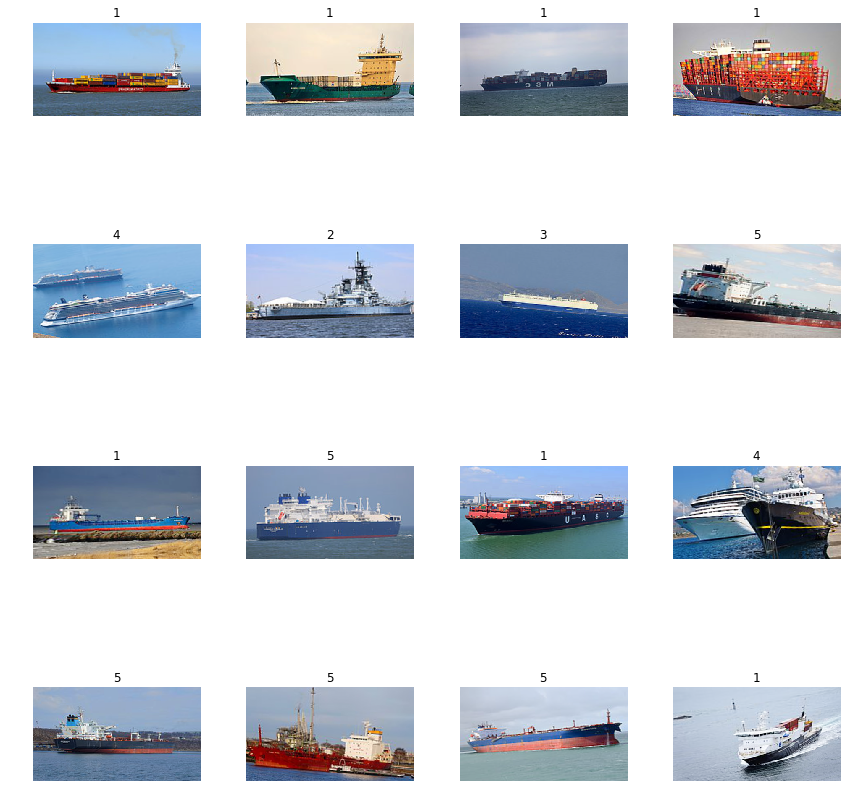

In [0]:
# display 6 rows of data
data.show_batch(rows=4, figsize=(12,13))

In [0]:
# verify the classes
print(data.classes)
len(data.classes),data.c

[1, 2, 3, 4, 5]


(5, 5)

In [0]:
#{'Cargo': 1, 'Military': 2, 'Carrier': 3, 'Cruise': 4, 'Tankers': 5}

In [8]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:02<00:00, 48179340.64it/s]


In [0]:
# fit 6 layers
learn.fit_one_cycle(6)

epoch,train_loss,valid_loss,accuracy,time
0,0.846860,0.470838,0.828535,10:24
1,0.535771,0.366613,0.856686,01:20
2,0.394909,0.320820,0.877159,01:18
3,0.310838,0.298976,0.894434,01:19
4,0.231573,0.276673,0.898912,01:17
5,0.206277,0.271388,0.898273,01:16


In [0]:
learn.save('stage-1')

In [0]:
learn.unfreeze()

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


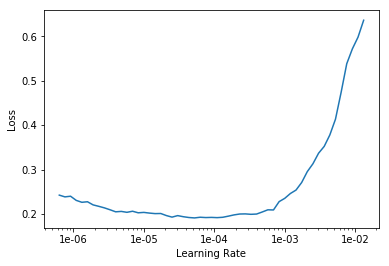

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(14,max_lr=slice(1.05E-05,1.0E-04))

epoch,train_loss,valid_loss,accuracy,time
0,0.194327,0.264712,0.904031,01:41
1,0.174590,0.244141,0.912348,01:40
2,0.148129,0.216857,0.923225,01:40
3,0.133736,0.194101,0.921305,01:40
4,0.099454,0.189641,0.928983,01:41
5,0.066483,0.185199,0.935381,01:40
6,0.049313,0.176372,0.936660,01:40
7,0.042264,0.167323,0.938580,01:40
8,0.034624,0.174182,0.939859,01:40
9,0.027008,0.174146,0.945617,01:40


In [0]:
learn.save('stage-2')

In [0]:
learn.load('stage-2');

In [0]:
#deploy your model
learn.export()
learn.export('trained_model.pkl')
path = learn.path
path

PosixPath('/content/drive/My Drive/Fast1ai/ship_category_hackathn/images')

In [0]:
learn = load_learner(path, 'trained_model.pkl')

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

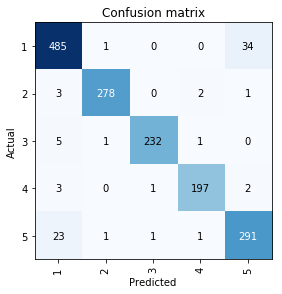

In [11]:
interp.plot_confusion_matrix()

In [0]:
# interpret the results
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

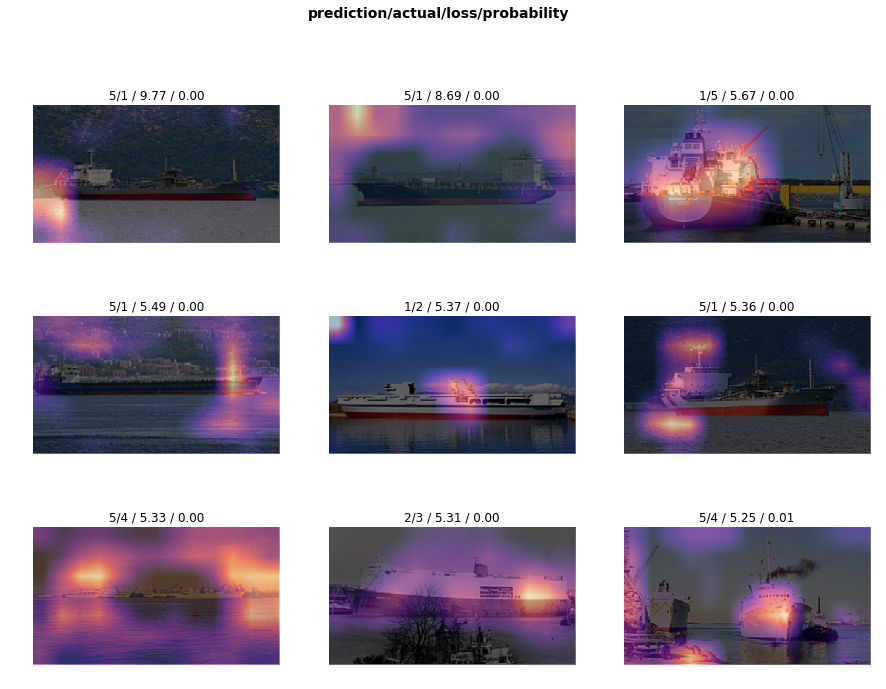

In [0]:
# plot the top losses
interp.plot_top_losses(9, figsize=(15,11))

In [0]:
from fastai.callbacks.hooks import *
def plot_top_losses_heatmap(k,learner, largest= True,figsize=(15,11)):
    tl_val,tl_idx = interp.top_losses(k,largest)
    print (tl_idx)
    classes = interp.data.classes
    rows = math.ceil(math.sqrt(k))
    fig,axes = plt.subplots(rows,rows,figsize=figsize)
    fig.suptitle('prediction/actual/loss/probability', weight='bold', size=14)
    for i,idx in enumerate(tl_idx):
        im,cl = interp.data.valid_ds[idx]
        cl = int(cl)
        ###
        xb,_ = data.one_item(im)
        xb = xb.cuda()
        m = learner.model.eval()
        with hook_output(m[0]) as hook_a:
            with hook_output(m[0], grad= True) as hook_g:
                preds = m(xb)
                preds[0,cl].backward()
        acts = hook_a.stored[0].cpu()
        avg_acts =acts.mean(0)
        sz = im.shape[-1]
        im.show(ax=axes.flat[i], title=
            f'{classes[interp.pred_class[idx]]}/{classes[cl]} / {interp.losses[idx]:.2f} / {interp.probs[idx][cl]:.2f}')
        axes.flat[i].imshow(avg_acts, alpha =0.6, extent= (0,sz,sz,0), interpolation='bilinear', cmap='magma')

tensor([ 438,    1, 1534, 1396,    5,    2,  897,  193,  896])


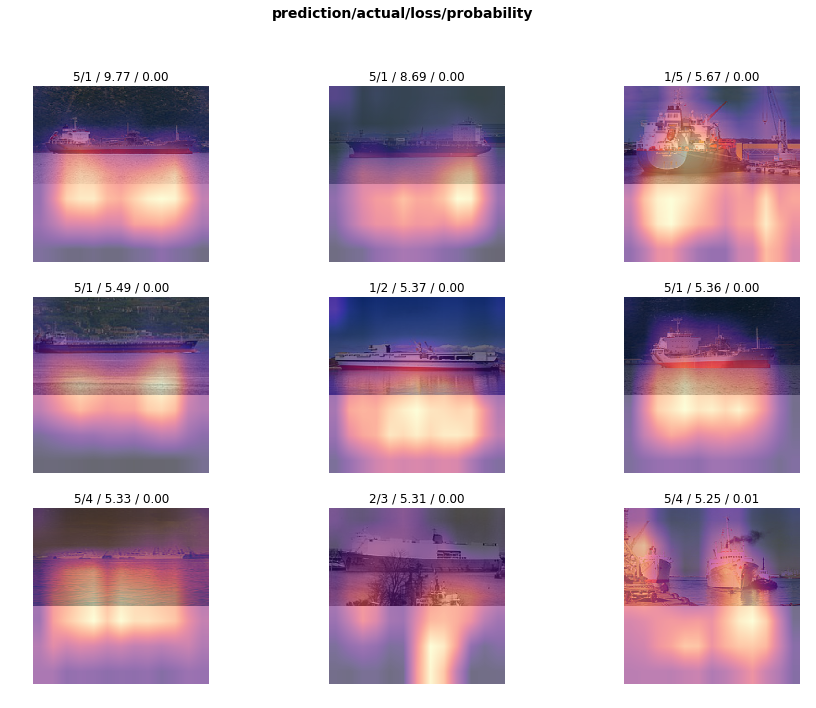

In [0]:
plot_top_losses_heatmap(9,learn,True)

#prediction 
learn.export()

In [0]:
test= (ImageList.from_csv(path, 'test.csv'))

In [16]:
len(test)

2680

In [0]:
learn = load_learner(path, test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [18]:
print(preds)

tensor([[1.0704e-07, 7.2389e-07, 6.0070e-08, 1.0000e+00, 1.9593e-06],
        [1.8054e-06, 4.5725e-07, 1.7248e-07, 9.9998e-01, 1.3518e-05],
        [7.9679e-04, 2.6689e-03, 3.0607e-06, 9.9556e-01, 9.7586e-04],
        ...,
        [2.8952e-02, 1.0692e-04, 6.8972e-04, 9.6907e-01, 1.1805e-03],
        [3.7555e-02, 1.0100e-02, 3.7867e-05, 9.5230e-01, 3.4476e-06],
        [4.2015e-05, 2.2155e-04, 8.7857e-07, 9.9968e-01, 5.7414e-05]])


In [19]:
preds.shape

torch.Size([2680, 5])

In [20]:
preds1 = np.argmax(preds, axis=1)
preds1,

(tensor([3, 3, 3,  ..., 3, 3, 3]),)

In [0]:
preds_list=preds1.tolist()

In [0]:
my_df = pd.DataFrame(preds_list)

In [0]:
my_df.to_csv('image_prob.csv')

In [0]:
pwd

'/content'